In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from PIL import Image
import os

dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

classes = os.listdir(dataset_path)

In [4]:
images = []
binary_labels = []


target_class = "panda"

In [5]:
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    # Iterate through each image in the class folder
    for image_name in os.listdir(class_path):
        # Load the image
        image_path = os.path.join(class_path, image_name)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        # Convert the image to numpy array and store it
        image_array = np.array(image)
        images.append(image_array)
        # Create binary labels for one-vs-rest classification
        label = 1 if class_name == target_class else 0
        binary_labels.append(label)

In [6]:
images = np.array(images)
binary_labels = np.array(binary_labels)

In [7]:
images.shape

(5400, 224, 224, 3)

In [8]:
label_1_index=[i for i in range(len(binary_labels)) if binary_labels[i]==1]
label_1_images=images[label_1_index]

In [9]:
import imgaug.augmenters as iaa
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontally flip 50% of the images
    iaa.Rotate((-10, 10)),  # rotate images by -10 to 10 degrees
    iaa.GaussianBlur(sigma=(0, 1.0)),  # apply gaussian blur
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # add gaussian noise
    iaa.Multiply((0.8, 1.2), per_channel=0.2),  # change brightness
])

augmented_images = augmentation(images=label_1_images)
images = np.concatenate([images, augmented_images], axis=0)
binary_labels = np.concatenate([binary_labels, np.ones(len(augmented_images))], axis=0)

In [10]:
images.shape[0]

5460

In [11]:
shuffle_indices = np.random.permutation(len(images))
images = images[shuffle_indices]
binary_labels = binary_labels[shuffle_indices]

In [12]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3),padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3),padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2024-02-26 03:59:53.009940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 03:59:53.010051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 03:59:53.306244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [14]:
np.unique(binary_labels)
binary_labels=binary_labels.astype(np.int16)

In [15]:
np.unique(binary_labels)

array([0, 1], dtype=int16)

In [17]:
k_folds = 3

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

kf = KFold(n_splits=k_folds, shuffle=True)


for train_index, test_index in kf.split(images, binary_labels):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = binary_labels[train_index], binary_labels[test_index]
    model.fit(X_train, y_train, epochs=15)
    
    loss, accuracy = model.evaluate(X_test, y_test)

    accuracy_scores.append(accuracy)
    y_pred = np.round(model.predict(X_test))
    precision_scores.append(precision_score(y_test, y_pred,pos_label=1))
    recall_scores.append(recall_score(y_test, y_pred,pos_label=1))
    f1_scores.append(f1_score(y_test, y_pred,pos_label=1))
    

# Print average performance across folds
print("Average Accuracy:", np.mean(accuracy_scores))
print("Average Precision:", np.mean(precision_scores))
print("Average Recall:", np.mean(recall_scores))
print("Average F1-Score:", np.mean(f1_scores))

Epoch 1/15
114/114 [==============================] - 5s 48ms/step - loss: 0.0079 - accuracy: 0.9986
Epoch 2/15
114/114 [==============================] - 5s 48ms/step - loss: 8.0406e-04 - accuracy: 1.0000
Epoch 3/15
114/114 [==============================] - 6s 49ms/step - loss: 7.5935e-04 - accuracy: 1.0000
Epoch 4/15
114/114 [==============================] - 6s 48ms/step - loss: 7.0382e-04 - accuracy: 1.0000
Epoch 5/15
114/114 [==============================] - 5s 48ms/step - loss: 0.0017 - accuracy: 0.9995
Epoch 6/15
114/114 [==============================] - 5s 47ms/step - loss: 0.0182 - accuracy: 0.9962
Epoch 7/15
114/114 [==============================] - 5s 47ms/step - loss: 0.0085 - accuracy: 0.9967
Epoch 8/15
114/114 [==============================] - 5s 47ms/step - loss: 0.0077 - accuracy: 0.9981
Epoch 9/15
114/114 [==============================] - 5s 47ms/step - loss: 0.0073 - accuracy: 0.9986
Epoch 10/15
114/114 [==============================] - 5s 47ms/step - loss: 0.0

171/171 [==============================] - 2s 13ms/step


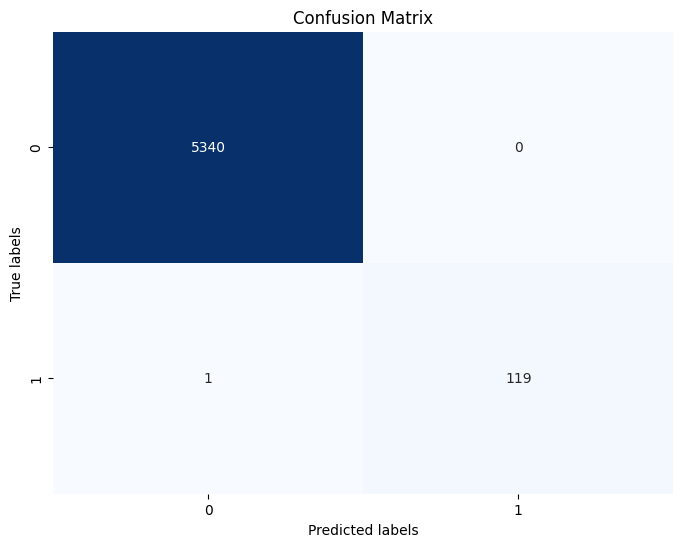

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(binary_labels, np.round(model.predict(images)))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [18]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

1/1 [==============================] - 0s 148ms/step


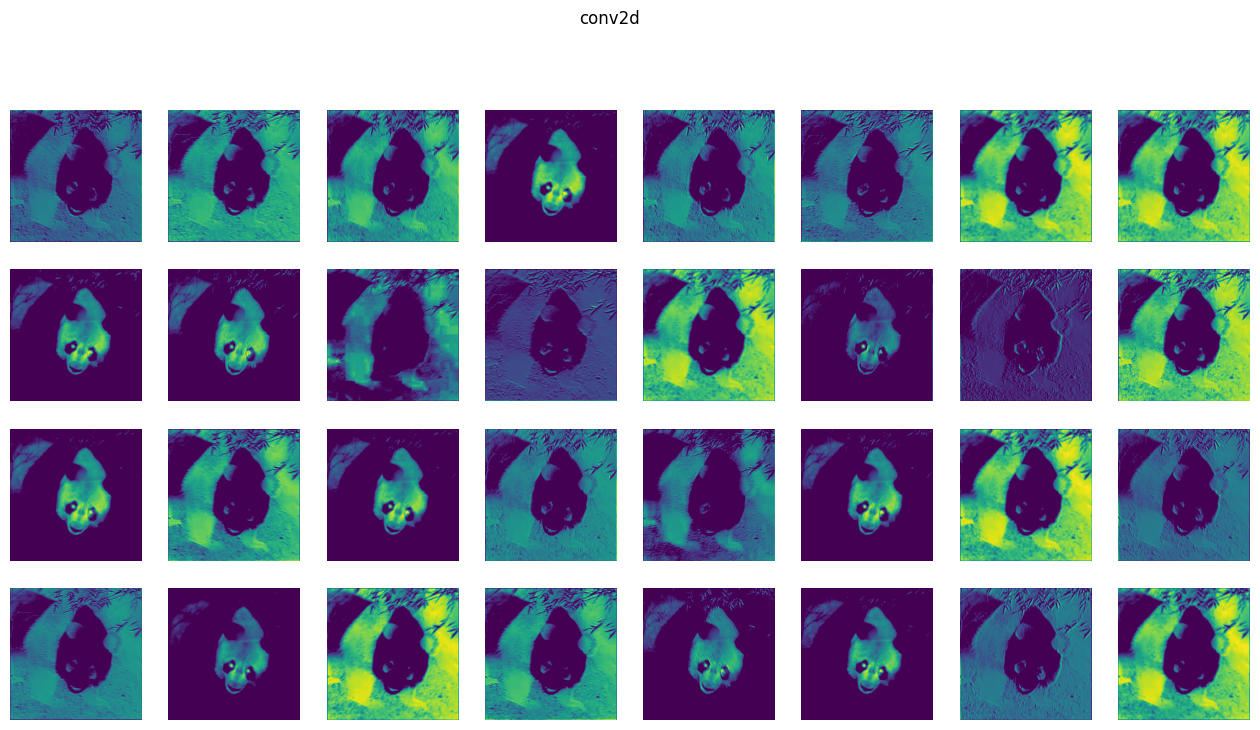

1/1 [==============================] - 0s 227ms/step


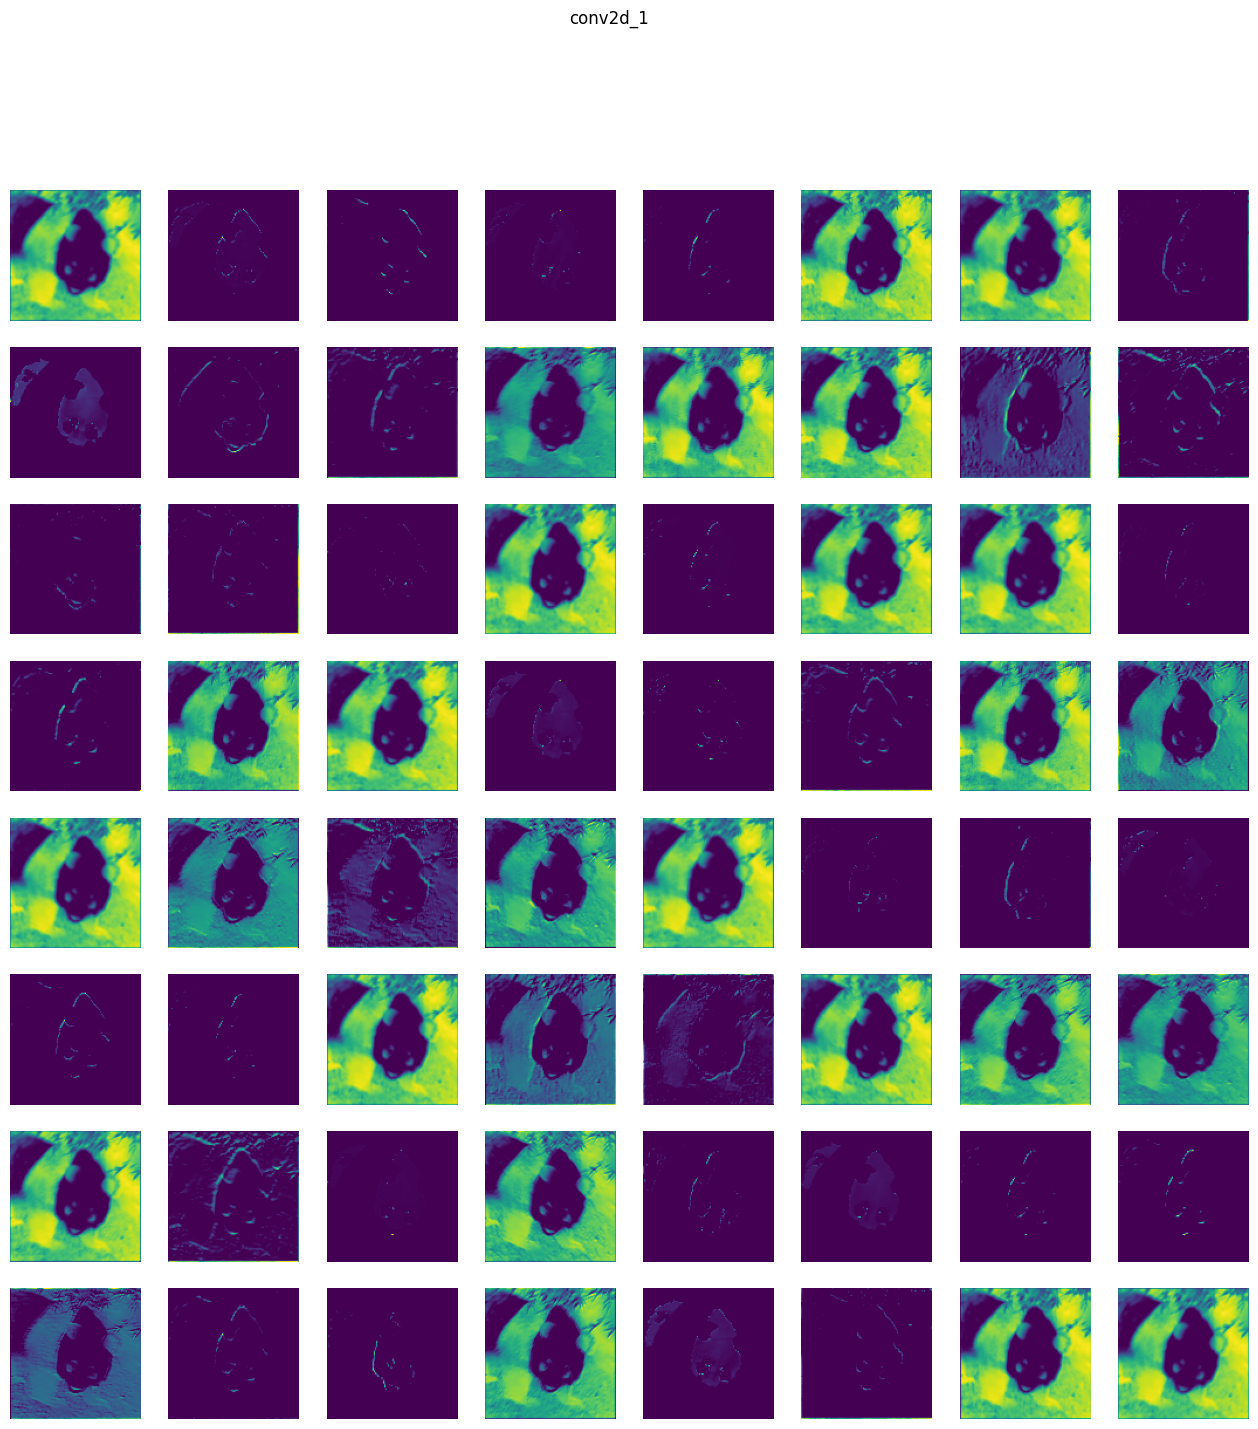

1/1 [==============================] - 0s 254ms/step


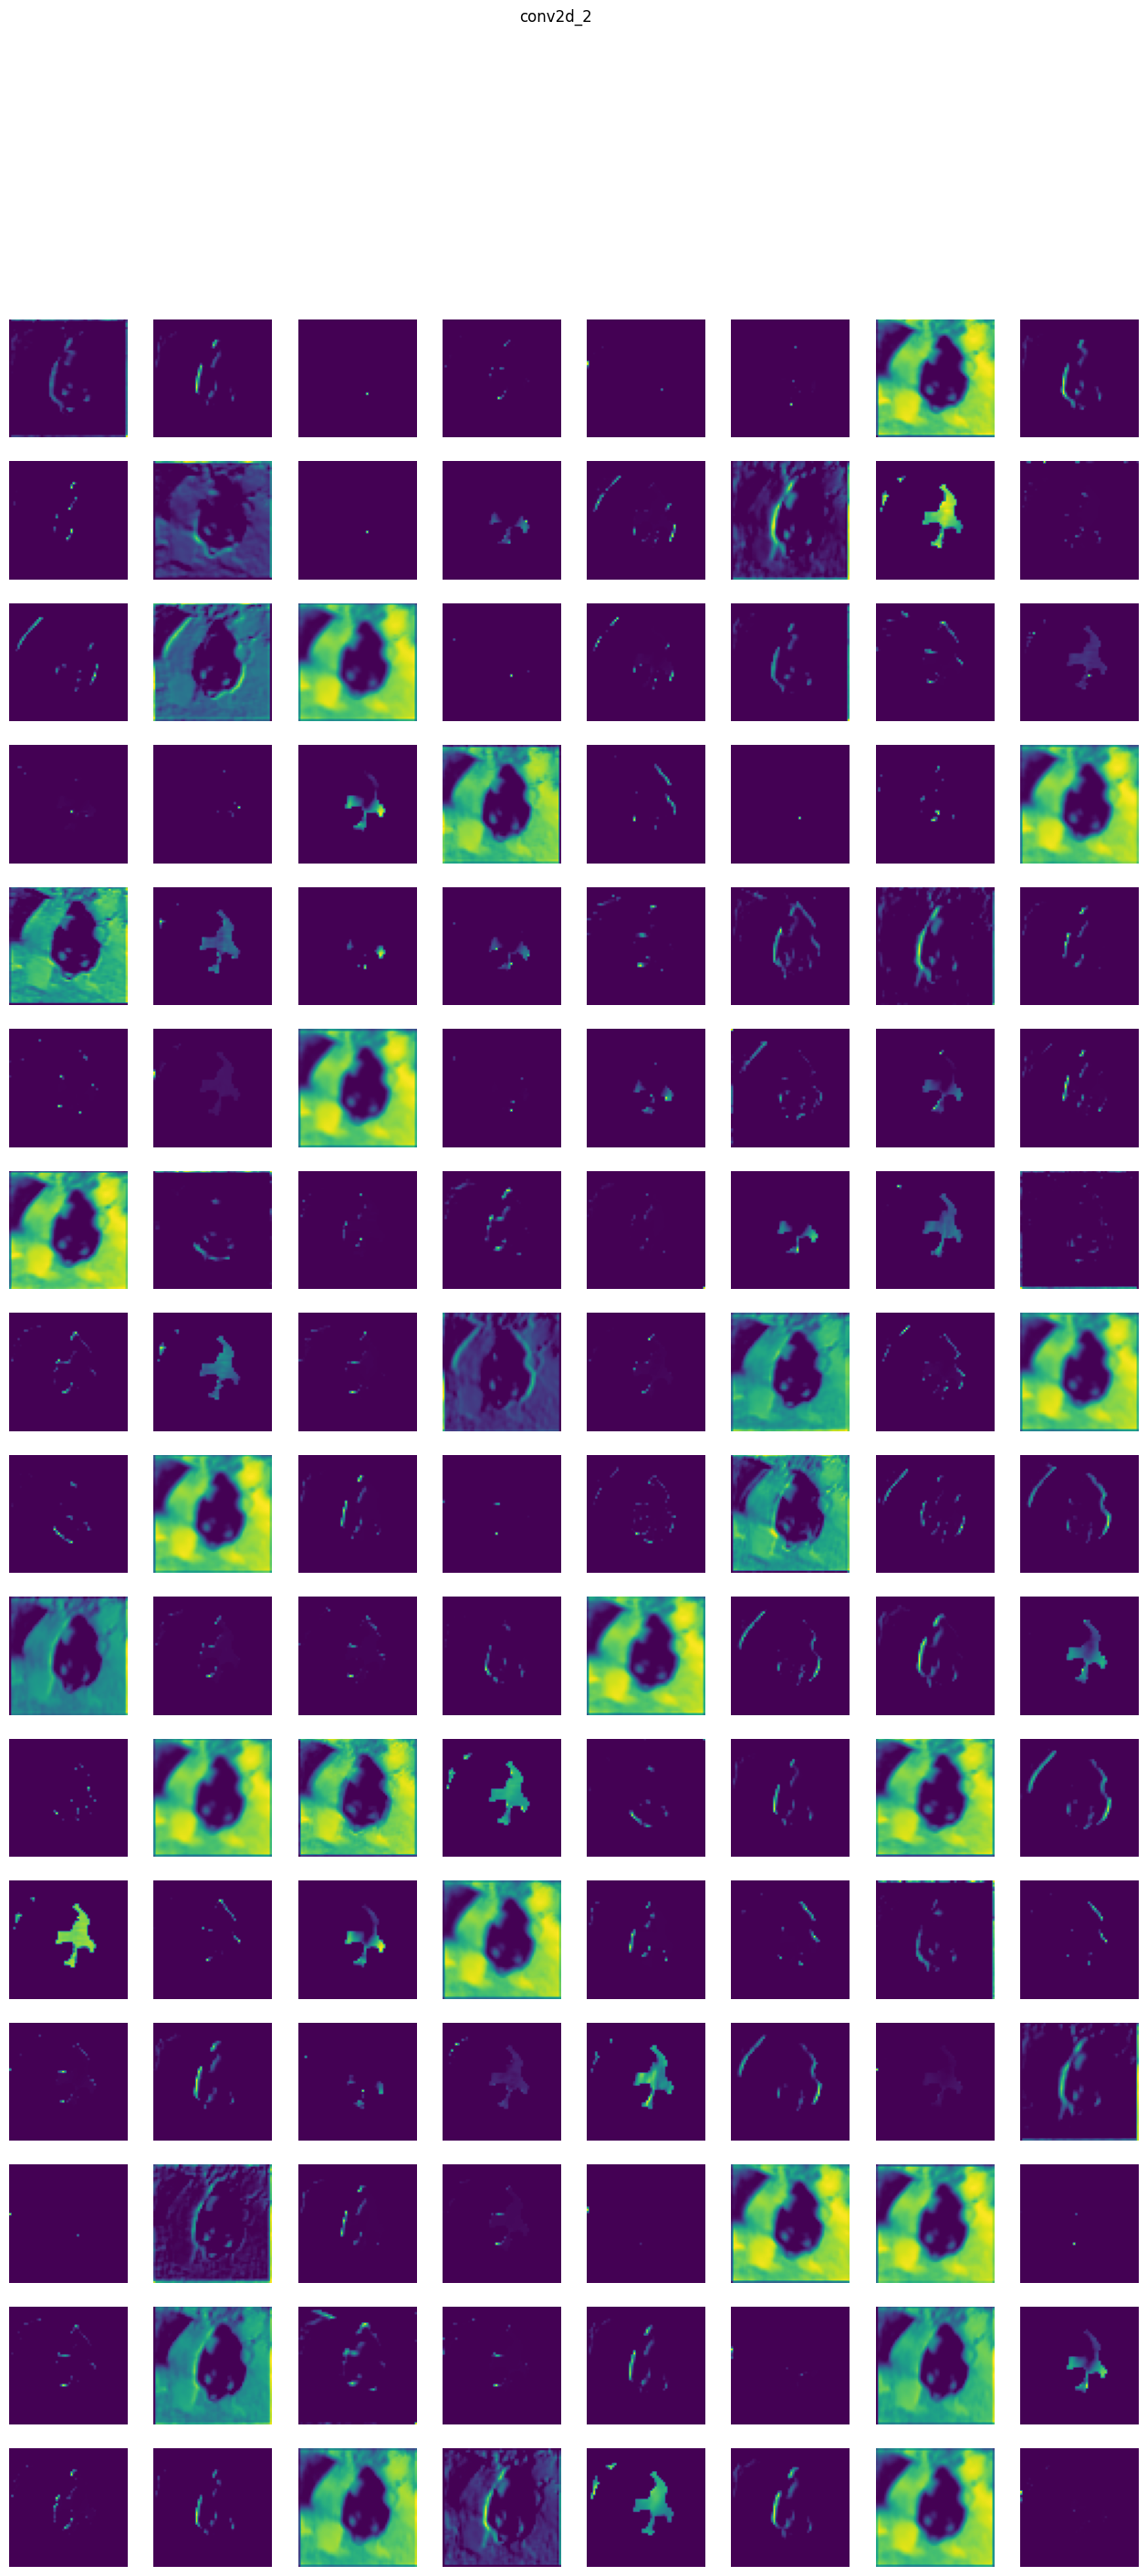

In [19]:
img_path = '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/panda/03b7ec608a.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

def plot_conv_output(layer_name):
    conv_layer = model.get_layer(layer_name)
    activation_model = models.Model(inputs=model.input, outputs=conv_layer.output)
    activations = activation_model.predict(img_tensor)
    
    num_filters = activations.shape[-1]
    columns = 8
    rows = num_filters // columns + 1
    
    plt.figure(figsize=(columns * 2, rows * 2))
    for i in range(num_filters):
        plt.subplot(rows, columns, i+1)
        plt.imshow(activations[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(layer_name)
    plt.show()

# Plot the output of all convolutional layers
for layer in model.layers:
    if isinstance(layer, layers.Conv2D):
        plot_conv_output(layer.name)